In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# load in the data

rawDF = pd.read_csv("injury_data.csv")

rawDF.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.251933,175.732429,1,0.457929,5,0
1,37,70.996271,174.581650,0,0.226522,6,1
2,32,80.093781,186.329618,0,0.613970,2,1
3,28,87.473271,175.504240,1,0.252858,4,1
4,25,84.659220,190.175012,0,0.577632,1,1


In [3]:
rawDF.isna().sum()

Player_Age              0
Player_Weight           0
Player_Height           0
Previous_Injuries       0
Training_Intensity      0
Recovery_Time           0
Likelihood_of_Injury    0
dtype: int64

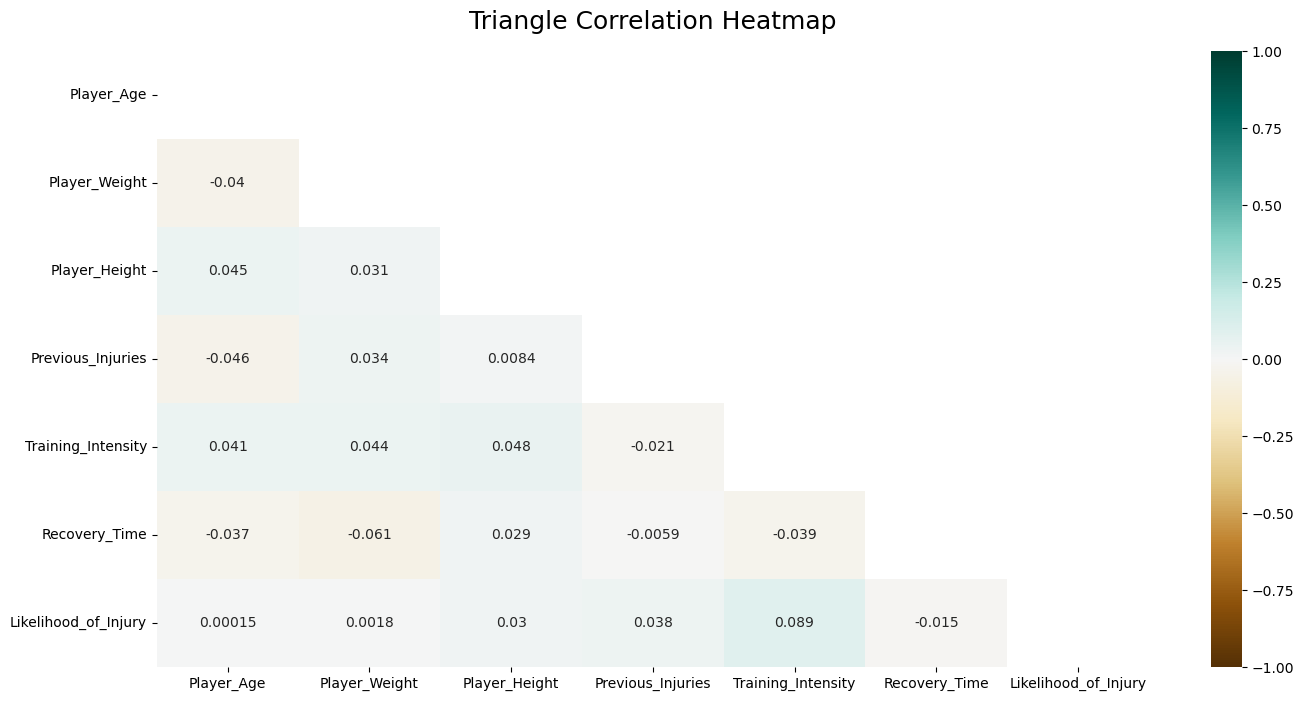

In [4]:
plt.figure(figsize=(16, 8))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(rawDF.corr(), dtype=np.bool_))
heatmap = sns.heatmap(rawDF.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

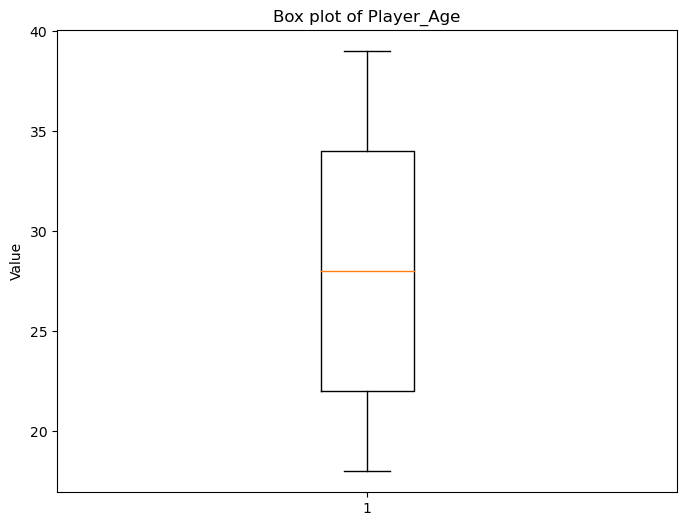

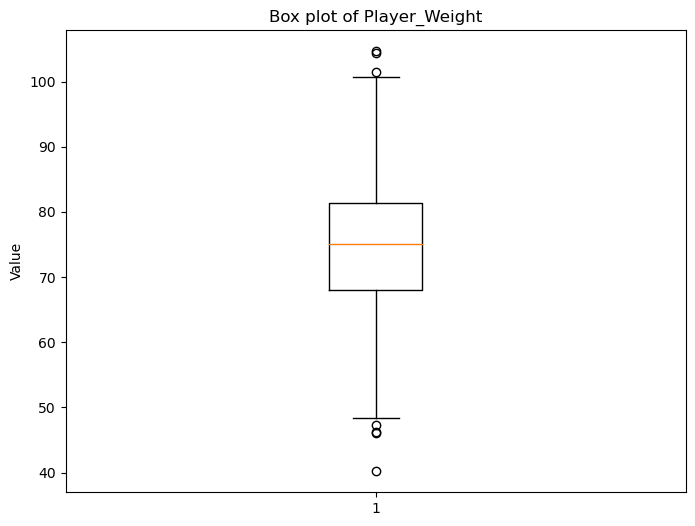

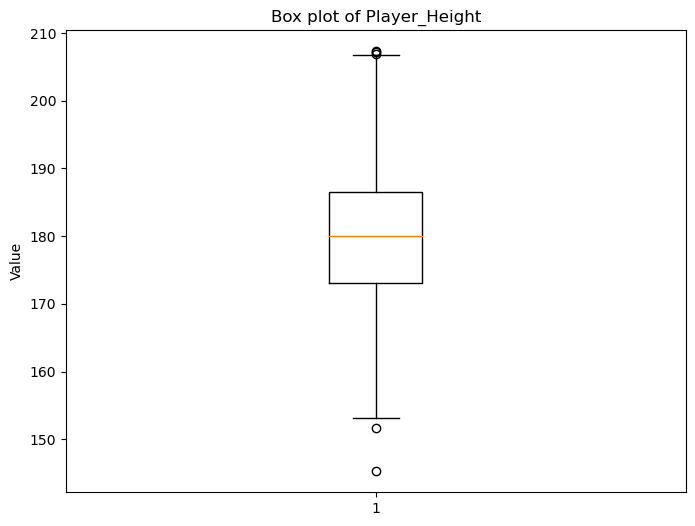

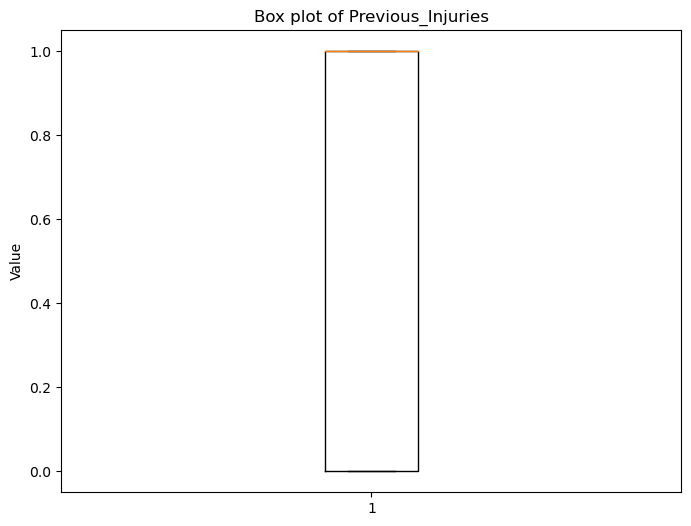

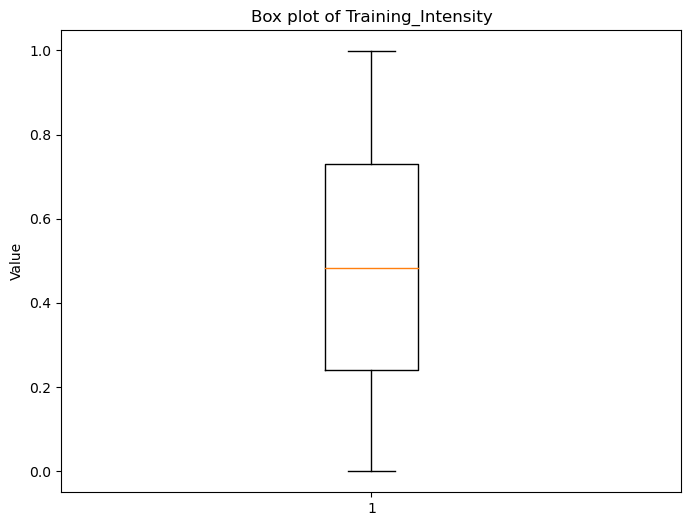

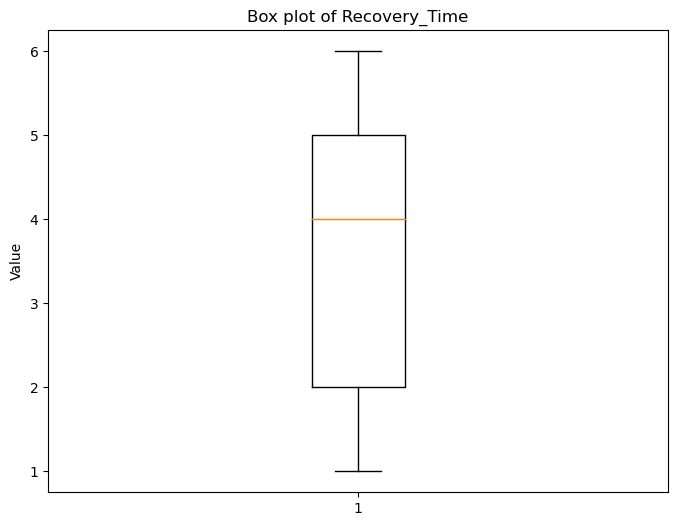

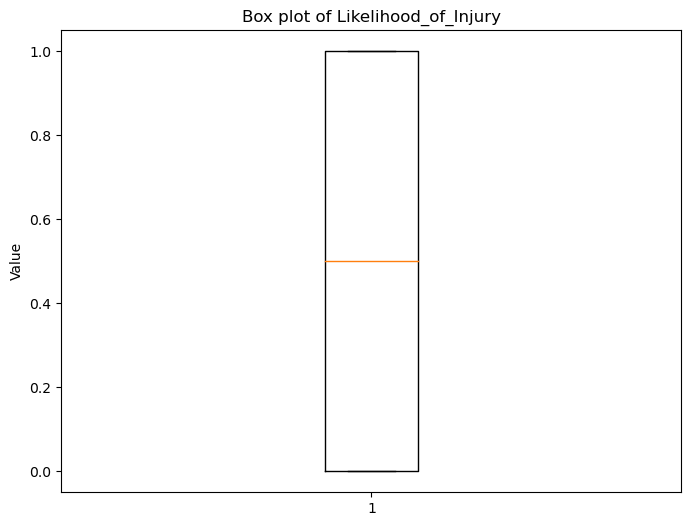

In [5]:
for column in rawDF.columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(rawDF[column])
    plt.title(f'Box plot of {column}')
    plt.ylabel('Value')
    plt.show()

In [6]:
yDF = rawDF["Likelihood_of_Injury"]
xDF = rawDF.drop(columns=["Likelihood_of_Injury"], axis=1)

print(xDF.columns)
xDF.head()

Index(['Player_Age', 'Player_Weight', 'Player_Height', 'Previous_Injuries',
       'Training_Intensity', 'Recovery_Time'],
      dtype='object')


,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time
0,24,66.251933,175.732429,1,0.457929,5
1,37,70.996271,174.581650,0,0.226522,6
2,32,80.093781,186.329618,0,0.613970,2
3,28,87.473271,175.504240,1,0.252858,4
4,25,84.659220,190.175012,0,0.577632,1


In [7]:
pd.DataFrame(yDF)

,Likelihood_of_Injury
0,0
1,1
2,1
3,1
4,1
...,...
995,1
996,0
997,1
998,0


In [8]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(
    xDF, yDF, 
    test_size=0.25,
    random_state=42)

In [9]:
from sklearn.preprocessing import StandardScaler

xScaler = StandardScaler()
xColNames = xTrain.columns.values.tolist()
# train the scaler and apply it to the training set
xTrainScaled = xScaler.fit_transform(xTrain[xColNames])

In [10]:
from sklearn.feature_selection import SelectKBest, f_regression

# score the different features and record it

fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(xTrain, yTrain)

fs.scores_

array([2.01746234e-01, 1.36125275e-02, 1.43795904e+00, 1.22874743e-03,
       5.84540699e+00, 9.43987837e-01])

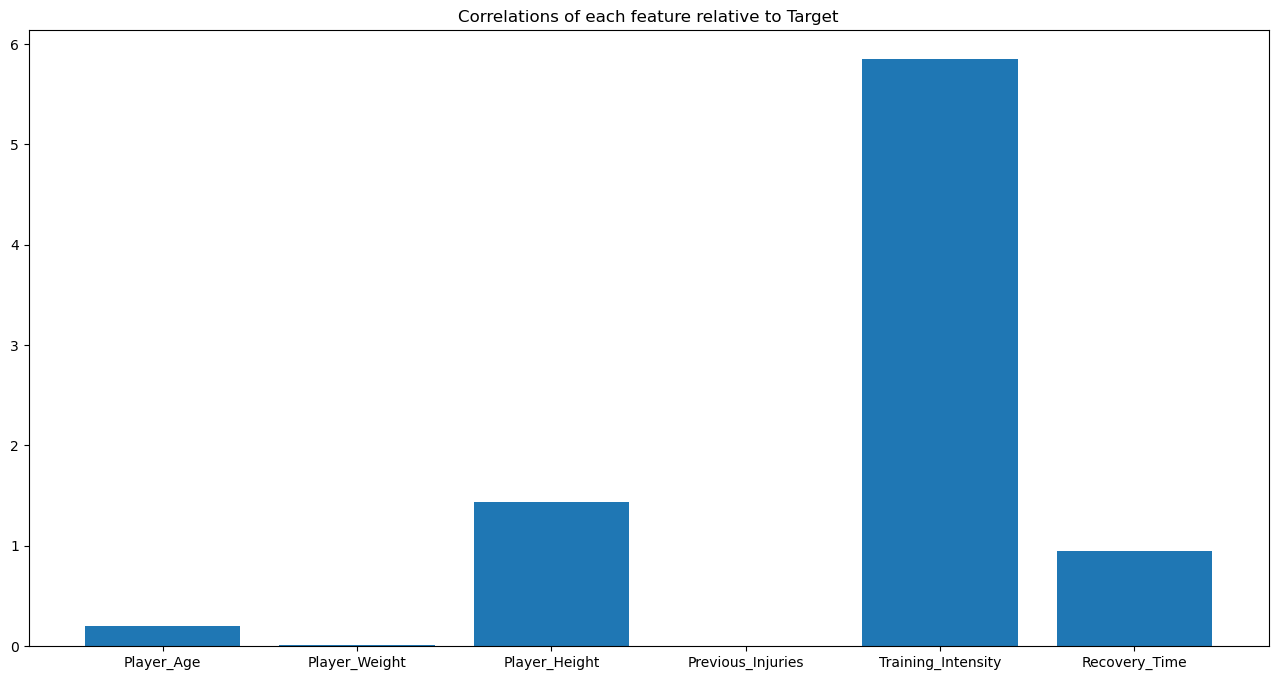

In [11]:
# plot the scores in a bar chart
plt.figure(figsize=(16, 8))
plt.bar([xTrain.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.title("Correlations of each feature relative to Target")
plt.show()

In [12]:
# f_regression is Pearson Correlation
from sklearn.feature_selection import SelectKBest, f_regression

# score the different features and record it

fs = SelectKBest(score_func=f_regression, k=6)
fs.fit(xTrain, yTrain)
# Get columns to keep and create new dataframe with those only
indices = fs.get_support(indices=True)
xTrain = xTrain.iloc[:,indices]
xTest = xTest.iloc[:,indices]

xTrain.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time
82,38,88.885823,197.929226,1,0.428458,4
991,25,65.808199,193.461783,1,0.909430,6
789,38,70.932769,197.015211,1,0.198632,1
894,23,70.458104,180.996058,0,0.422192,4
398,34,99.020263,171.797587,1,0.057027,5


In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(xTrain, yTrain)
preds = model.predict(xTest)

print(r2_score(yTest, preds))
print(mean_absolute_error(yTest, preds))

-0.017117741361203365
0.49905298916966806


In [14]:
from sklearn import svm

svmModel = svm.SVR().fit(xTrain, yTrain)

preds = svmModel.predict(xTest)

print(r2_score(yTest, preds))
print(mean_absolute_error(yTest, preds))

-0.7956029641184066
0.5381128603702237


In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# Define parameters for linear regression
linear_parameters = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

# Create linear regression model
linear_model = LinearRegression()

# Perform grid search with 5-fold cross-validation
linear_grid_search = GridSearchCV(estimator=linear_model,
                                  param_grid=linear_parameters,
                                  scoring={'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)},
                                  cv=5,
                                  refit='r2',
                                  verbose=1)

# Fit the grid search to the data
linear_grid_search.fit(xTrain, yTrain)

# Get the best parameters
linear_best_params = linear_grid_search.best_params_
print("Linear Regression - Best Parameters:", linear_best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Linear Regression - Best Parameters: {'fit_intercept': False, 'positive': True}


In [17]:
from sklearn.linear_model import LogisticRegression

parameters = [{'penalty':['l1', 'l2'], 
              'C':[1, 10, 100, 1000]}]
gridSearch = GridSearchCV(estimator = LogisticRegression(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0)


gridSearch.fit(xTrainScaled, yTrain) 

logisticParams = gridSearch.best_params_

logisticParams

c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _

{'C': 10, 'penalty': 'l2'}

In [18]:
from sklearn.svm import SVC

parameters = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear','rbf']}
gridSearch = GridSearchCV(estimator = SVC(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0)


gridSearch.fit(xTrainScaled, yTrain) 

svmParams = gridSearch.best_params_

svmParams

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [19]:
from sklearn.neural_network import MLPClassifier

parameters = parameter_space = {
    'max_iter': [1000],
    'hidden_layer_sizes': [(50,50), (50,50,50), (100)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
gridSearch = GridSearchCV(estimator = MLPClassifier(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0)


gridSearch.fit(xTrainScaled, yTrain) 

mlpParams = gridSearch.best_params_

mlpParams

c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorda\anaconda3\Lib\site-packages\sklearn\neural_network\_m

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'solver': 'adam'}

In [20]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None, 'sqrt', 'log2']}

              
gridSearch = GridSearchCV(estimator = DecisionTreeClassifier(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0)


gridSearch.fit(xTrainScaled, yTrain) 

treeParams = gridSearch.best_params_

treeParams

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'best'}

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [22]:
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = LogisticRegression(C=10, penalty='l2')
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

Completed Fold 0
    Accuracy=0.5666666666666667    Recall=0.4025974025974026    FScore=0.4881889763779527
Completed Fold 1
    Accuracy=0.5733333333333334    Recall=0.5301204819277109    FScore=0.5789473684210525
Completed Fold 2
    Accuracy=0.5133333333333333    Recall=0.35294117647058826    FScore=0.3966942148760331
Completed Fold 3
    Accuracy=0.54    Recall=0.4647887323943662    FScore=0.4888888888888889
Completed Fold 4
    Accuracy=0.4866666666666667    Recall=0.44871794871794873    FScore=0.4761904761904762


In [23]:
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = DecisionTreeClassifier(criterion='gini',
                                 max_depth=10,
                                 max_features='log2',
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 splitter='best')
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

Completed Fold 0
    Accuracy=0.74    Recall=0.7012987012987013    FScore=0.7346938775510204
Completed Fold 1
    Accuracy=0.6533333333333333    Recall=0.5301204819277109    FScore=0.6285714285714286
Completed Fold 2
    Accuracy=0.66    Recall=0.7205882352941176    FScore=0.6577181208053691
Completed Fold 3
    Accuracy=0.7066666666666667    Recall=0.5774647887323944    FScore=0.6507936507936508
Completed Fold 4
    Accuracy=0.6333333333333333    Recall=0.5512820512820513    FScore=0.6099290780141844


In [24]:
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = SVC(C=100, gamma=0.1, kernel='rbf')
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

Completed Fold 0
    Accuracy=0.6466666666666666    Recall=0.7012987012987013    FScore=0.6708074534161491
Completed Fold 1
    Accuracy=0.7    Recall=0.7228915662650602    FScore=0.7272727272727273
Completed Fold 2
    Accuracy=0.68    Recall=0.7205882352941176    FScore=0.6712328767123287
Completed Fold 3
    Accuracy=0.6666666666666666    Recall=0.7746478873239436    FScore=0.6875
Completed Fold 4
    Accuracy=0.6933333333333334    Recall=0.6923076923076923    FScore=0.7012987012987013


In [25]:
from sklearn.neural_network import MLPClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = MLPClassifier(activation='relu',
                        alpha=0.05,
                        hidden_layer_sizes=(50, 50, 50),
                        learning_rate='constant',
                        max_iter=1000,
                        solver='adam')
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

Completed Fold 0
    Accuracy=0.8333333333333334    Recall=0.8181818181818182    FScore=0.8344370860927152
Completed Fold 1
    Accuracy=0.8466666666666667    Recall=0.8795180722891566    FScore=0.863905325443787
Completed Fold 2
    Accuracy=0.7866666666666666    Recall=0.7205882352941176    FScore=0.7538461538461538
Completed Fold 3
    Accuracy=0.8    Recall=0.8169014084507042    FScore=0.7945205479452055
Completed Fold 4
    Accuracy=0.82    Recall=0.8333333333333334    FScore=0.8280254777070064
